# 00 — Data Loading Tutorial

Demonstrates the full `MiceDataset` API: subject metadata, recording discovery, raw and processed data loading, and tuning-curve computation.

In [1]:
from remapping.dataset import MiceDataset, Animals, MiceDataType
from remapping.processing import smooth_tuning_curves_circularly
from remapping.plotting import BehaviorColors, PlotStyle, get_figures_path

import numpy as np
import matplotlib.pyplot as plt

mice = MiceDataset()
colors = BehaviorColors()
style = PlotStyle()

## 1. Subject metadata

In [2]:
print("Genotypes:", mice.get_genotypes())
print("Ages:     ", mice.get_ages())
print()

for genotype in mice.get_genotypes():
    for age in mice.get_ages():
        group = mice.get_subjects_by_group(genotype, age)
        print(f"{genotype} {age}: {len(group)} mice — {[s.value for s in group]}")

Genotypes: ['5xFAD', 'WT']
Ages:      ['old', 'young']

5xFAD old: 6 mice — ['m111', 'm118', 'm125', 'm139', 'm140', 'm141']
5xFAD young: 5 mice — ['m77', 'm79', 'm121', 'm128', 'm132']
WT old: 6 mice — ['m62', 'm66', 'm70', 'm116', 'm117', 'm133']
WT young: 6 mice — ['m120', 'm127', 'm129', 'm130', 'm134', 'm135']


## 2. Discover recordings for one subject

In [4]:
subject = Animals.M125

fovs = mice.get_available_fovs(subject)
print(f"{subject.value}: FOVs = {fovs}")

for fov in fovs:
    sessions = mice.get_available_sessions(subject, fov)
    print(f"  fov{fov}: sessions = {sessions}")
    for session in sessions:
        runs = mice.get_available_runs(subject, fov, session)
        print(f"    {session}: runs = {runs}")

m125: FOVs = [1]
  fov1: sessions = ['fam1fam2fam1', 'fam1novfam1', 'fam1fam1revfam1']
    fam1fam2fam1: runs = ['fam1', 'fam2', 'fam1r2']
    fam1novfam1: runs = ['fam1', 'nov', 'fam1r2']
    fam1fam1revfam1: runs = ['fam1', 'fam1rev', 'fam1r2']


## 3. Load raw data with `load_data()`

In [5]:
# Pick first available recording
fov = fovs[0]
session = mice.get_available_sessions(subject, fov)[0]
run = mice.get_available_runs(subject, fov, session)[0]

print(f"Loading: {subject.value} fov{fov} {session}-{run}")
df_raw = mice.load_data(subject, fov, session, run, MiceDataType.SPIKES)
print(f"Shape: {df_raw.shape}")
df_raw.head()

Loading: m125 fov1 fam1fam2fam1-fam1
Shape: (59360, 183)


,animal,experiment,run,fov,time,glob_time,phi,x,y,movement_status,...,170,172,173,174,175,176,177,178,179,182
0,m125,fam1fam2fam1,fam1,fov1,0.016000,0.000000,27.108442,64.091441,-125.200166,stationary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,m125,fam1fam2fam1,fam1,fov1,0.048362,0.032362,33.051508,74.701342,-114.803898,stationary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,m125,fam1fam2fam1,fam1,fov1,0.080725,0.064725,35.943617,79.340036,-109.428484,stationary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,m125,fam1fam2fam1,fam1,fov1,0.113087,0.097087,37.901397,81.811528,-105.086249,moving,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,m125,fam1fam2fam1,fam1,fov1,0.145450,0.129450,38.918371,82.946598,-102.729429,moving,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Load processed data with `load_all_data_from_spikes_binned_smoothed()`

In [6]:
firing_rates, phi, time, (cells, registered), tc, phi_bins = (
    mice.load_all_data_from_spikes_binned_smoothed(
        subject, fov, session, run,
        only_moving=False,
        bins_compress=3,
        bins_smoothing=3,
        bins_phi=360,
    )
)

print(f"Firing rates: {firing_rates.shape}  (T' x N)")
print(f"Tuning curves: {tc.shape}  (bins_phi x N)")
print(f"Registered across days: {registered}")
print(f"Global cell IDs (first 5): {cells[:5]}")

Firing rates: (19786, 170)  (T' x N)
Tuning curves: (360, 170)  (bins_phi x N)
Registered across days: True
Global cell IDs (first 5): ['64', '65', '1', '21', '39']


## 5. Effect of parameters

In [7]:
# Compare bins_phi = 36 vs 360
for bp in [36, 180, 360]:
    fr, ph, t, _, tc_bp, _ = mice.load_all_data_from_spikes_binned_smoothed(
        subject, fov, session, run, bins_phi=bp,
    )
    print(f"bins_phi={bp:>3d} → tuning curves shape: {tc_bp.shape}")

bins_phi= 36 → tuning curves shape: (36, 170)
bins_phi=180 → tuning curves shape: (180, 170)
bins_phi=360 → tuning curves shape: (360, 170)


## 6. Plot example tuning curves

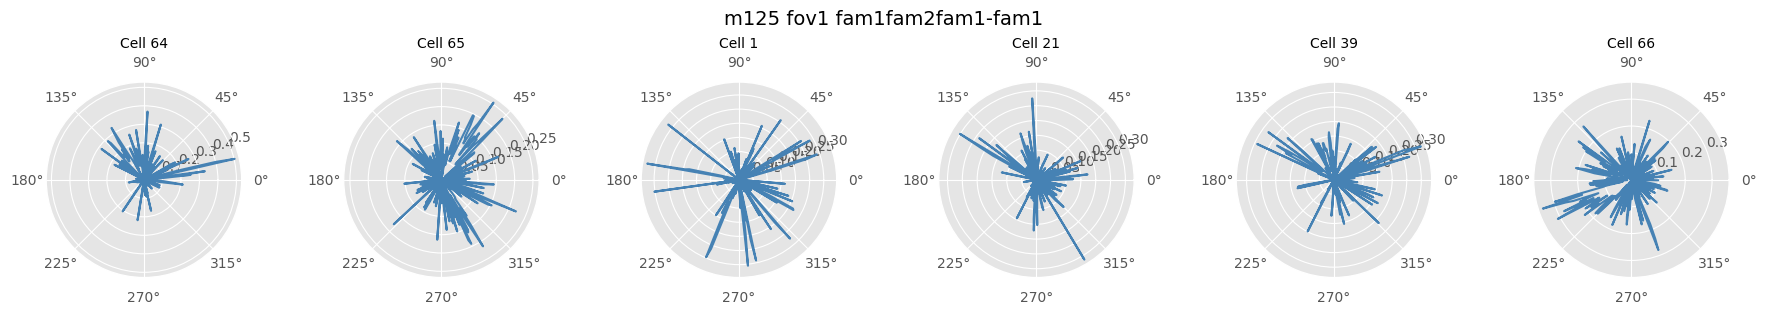

In [8]:
n_show = min(6, tc.shape[1])
fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3), subplot_kw={"projection": "polar"})
phi_rad = np.deg2rad(phi_bins)

for i, ax in enumerate(axes):
    ax.plot(phi_rad, tc[:, i], color="steelblue")
    ax.set_title(f"Cell {cells[i]}", fontsize=10)

fig.suptitle(f"{subject.value} fov{fov} {session}-{run}", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Circular smoothing of tuning curves

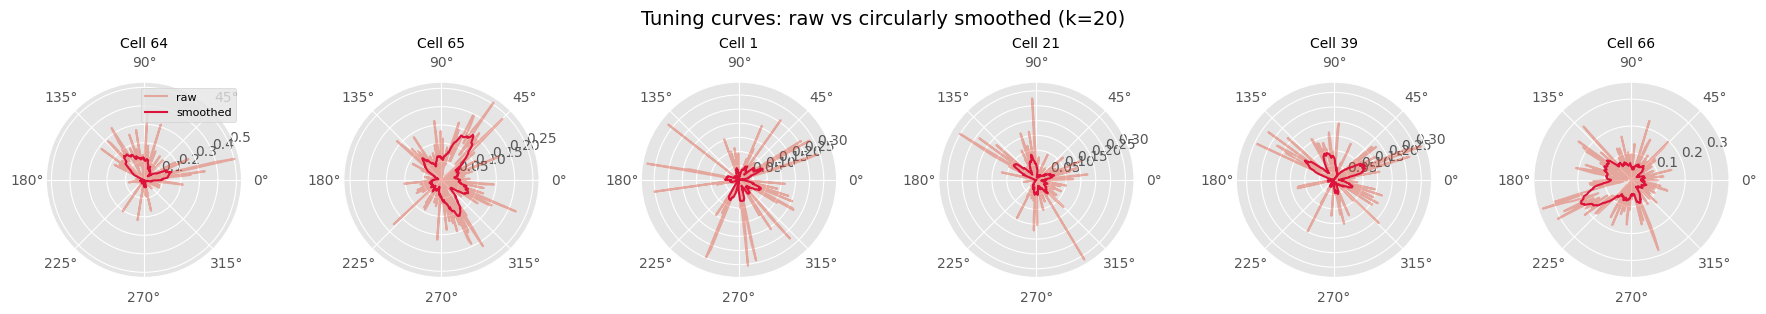

In [9]:
tc_smooth = smooth_tuning_curves_circularly(tc, kernel_size=20)

fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3), subplot_kw={"projection": "polar"})
for i, ax in enumerate(axes):
    ax.plot(phi_rad, tc[:, i], alpha=0.4, label="raw")
    ax.plot(phi_rad, tc_smooth[:, i], color="crimson", label="smoothed")
    ax.set_title(f"Cell {cells[i]}", fontsize=10)

axes[0].legend(loc="upper right", fontsize=8)
fig.suptitle("Tuning curves: raw vs circularly smoothed (k=20)", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Firing-rate traces

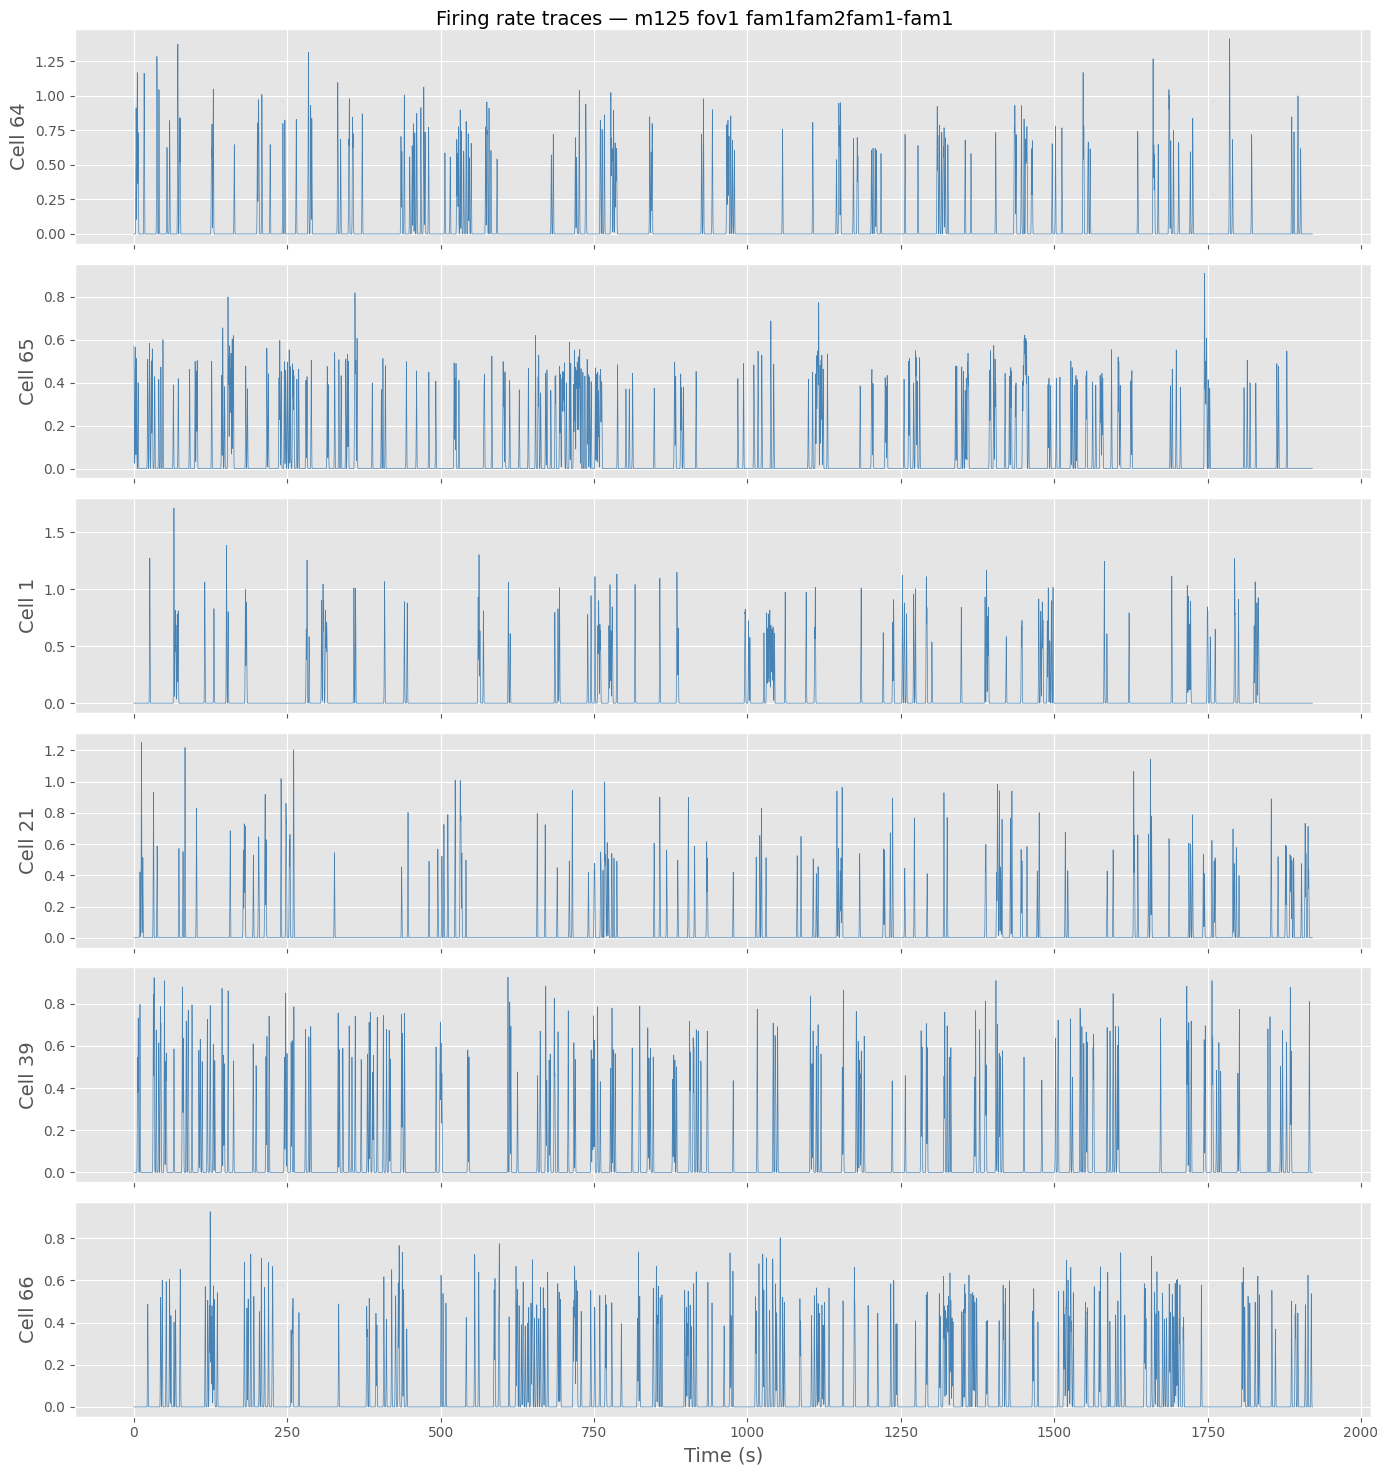

In [10]:
fig, axes = plt.subplots(n_show, 1, figsize=(14, 2.5 * n_show), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(time, firing_rates[:, i], linewidth=0.5, color="steelblue")
    ax.set_ylabel(f"Cell {cells[i]}")

axes[-1].set_xlabel("Time (s)")
fig.suptitle(f"Firing rate traces — {subject.value} fov{fov} {session}-{run}", fontsize=14)
plt.tight_layout()
plt.show()